# Maps

## Agenda

- Discussion: pros/cons of array-backed and linked structures
- Comparison to `set` and `dict`
- The **Map** ADT
- Direct lookups via *Hashing*
- Hashtables
    - Collisions and the "Birthday problem"
- Runtime analysis & Discussion

## Discussion: pros/cons of array-backed and linked structures

Between the array-backed and linked list we have:

1. $O(1)$ indexing (array-backed)
2. $O(1)$ appending (array-backed & linked)
3. $O(1)$ insertion/deletion without indexing (linked)
4. $O(N)$ linear search (unsorted)
5. $O(\log N)$ binary search, when sorted (only array-backed lists)

## Comparison to `set` and `dict`

The `set` and `dict` types don't support positional access (i.e., by index), but do support lookup/search. How fast do they fare compared to lists?

In [1]:
def lin_search(lst, x):
    for y in lst:
        if x == y:
            return True
    else:
        return False
    
def bin_search(lst, x):
    # assumes lst is sorted
    low = 0
    hi  = len(lst)-1
    while low <= hi:
        mid = (low + hi) // 2
        if x < lst[mid]:
            hi  = mid - 1
        elif x < lst[mid]:
            low = mid + 1
        else:
            return True
    else:
        return False

In [2]:
import timeit
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6] # set size of plot

ns = np.linspace(100, 10_000, 50, dtype=int)

ts_linsearch = [timeit.timeit('lin_search(lst, lst[-1])',
                              setup=f'lst = list(range({n}))',
                              globals=globals(),
                              number=100)
                for n in ns]

ts_binsearch = [timeit.timeit('bin_search(lst, 0)',
                              setup=f'lst = list(range({n}))',
                              globals=globals(),
                              number=100)
                for n in ns]

ts_setadd    = [timeit.timeit(f'st.add({n})',
                              setup=f'st = set(range({n}))',
                              globals=globals(),
                              number=100)
                for n in ns]


ts_setsearch = [timeit.timeit(f'{0} in st', # try for other values
                              setup=f'st = set(range({n}))',
                              globals=globals(),
                              number=100)
                for n in ns]

ts_dctadd    = [timeit.timeit(f'dct[{n}] = 0',
                              setup=f'dct = {{x:x for x in range({n})}}',
                              globals=globals(),
                              number=100)
                for n in ns]

ts_dctsearch = [timeit.timeit(f'{0} in dct', # try for other values
                              setup=f'dct = {{x:x for x in range({n})}}',
                              globals=globals(),
                              number=100)
                for n in ns]

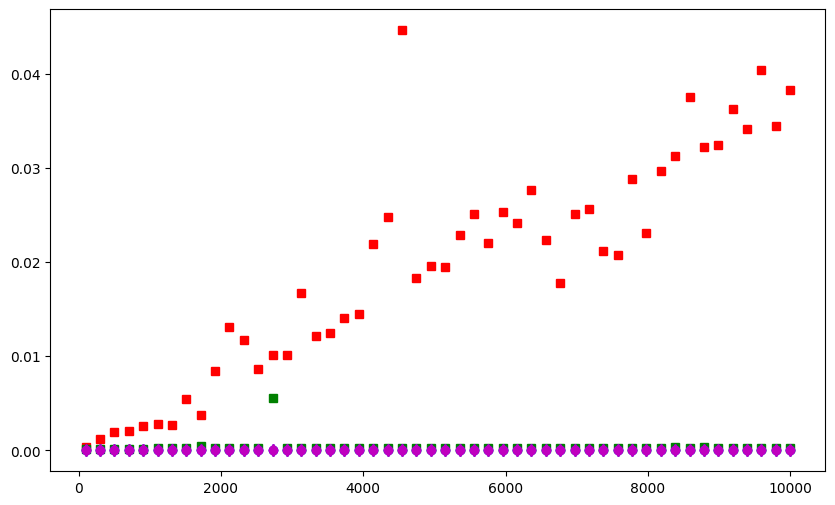

In [3]:
plt.plot(ns, ts_linsearch, 'sr')
plt.plot(ns, ts_binsearch, 'sg')
plt.plot(ns, ts_setadd, 'db')
plt.plot(ns, ts_setsearch, 'ob')
plt.plot(ns, ts_dctadd, 'dm');
plt.plot(ns, ts_dctsearch, 'om');

Somehow, by discarding positional access and manipulation, sets and dictionaries appear to be able to implement insertion and search in **constant time**!

How is this magic possible?

## The **Map** ADT

We will focus next on the "*map*" abstract data type (aka "associative array" or "dictionary"), which is used to associate keys (which must be unique) with values. 

A map *does not* intrinsically impose any ordering on its contents --- i.e., an implementation of a map does not need to support positional access to keys, nor report a consistent view of key order.

Python's `dict` type is an implementation of the map ADT. 

### But what about sets?

Given an implementation of a map, it should be straightforward to use it to implement a set:

In [ ]:
class MySet:
    def __init__(self):
        self.dct = dict()
    
    def add(self, value):
        pass
    
    def __contains__(self, value):
        pass
        
    def intersection(self, other):
        assert isinstance(other, MySet)
        pass
    
    def __iter__(self):
        return iter(self.dct)
            
    def __repr__(self):
        return '{' + ', '.join(repr(x) for x in self) + '}'

In [ ]:
st = MySet()

for c in 'hello world!':
    st.add(c)

st

In [ ]:
set('hello world!')

In [ ]:
st2 = MySet()

for c in 'farewell planet':
    st2.add(c)
    
st.intersection(st2)

In [ ]:
set('hello world!') & set('farewell planet')

### A simple map implementation

In [4]:
class MapDS:
    def __init__(self):
        self.data = []
    
    def __setitem__(self, key, value):
        pass
    
    def __getitem__(self, key):
        pass
            
    def __contains__(self, key):
        pass

In [5]:
m = MapDS()
m['batman'] = 'bruce wayne'
m['superman'] = 'clark kent'
m['spiderman'] = 'peter parker'

In [6]:
m['batman']

In [7]:
m['batman'] = 'tony stark'

In [8]:
m['batman']

How can we make the leap from linear runtime complexity to constant?!

## Direct lookups via *Hashing*

Hashes (a.k.a. hash codes or hash values) are simply numerical values computed for objects.

In [9]:
hash('hello')

-8160918942862550364

In [10]:
hash('batman')

7406969507461251652

In [11]:
hash('batmen') 

-4292993310547553500

In [12]:
[hash(s) for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[7688825157942264,
 444183089132950045,
 -2856603719115513659,
 -1578220134576504599,
 7688825157942264,
 -1765820219602982200]

In [13]:
[hash(s)%100 for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[64, 45, 41, 1, 64, 0]

### Random Hashing

The `hash` function in Python is *randomized* by default -- i.e., each time a Python interpreter is fired up, the implementation of `hash` will use a different "seed" for the random number generator used in computing hashes. While hashcodes computed for a given value will be consistent for a given interpreter instance, they will not be across instances! This means we shouldn't save hashcodes for values to disk, or save them to a database, as values will almost certainly hash to different hashcodes after we restart our software!

Why does Python do this? More later!

## Hashtables

A **hashtable** is an implementation of the map ADT that uses the hashcode for a key to compute an index into an array where the corresponding key/value pair will be stored.

In [ ]:
class Hashtable:
    def __init__(self, n_buckets):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        pass
    
    def __getitem__(self, key):
        pass
        
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [ ]:
ht = Hashtable(100)
ht['spiderman'] = 'peter parker'
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'

In [ ]:
ht['spiderman']

In [ ]:
ht['batman']

In [ ]:
ht['superman']

## On Collisions

### The "Birthday Problem"

Problem statement: Given $N$ people at a party, how likely is it that at least two people will have the same birthday?

### Collision Probabilities

In [ ]:
def birthday_p(n_people):
    p_inv = 1
    for n in range(365, 365-n_people, -1):
        p_inv *= n / 365
    return 1 - p_inv

In [ ]:
birthday_p(3)

In [ ]:
1-364/365*363/365

In [ ]:
n_people = range(1, 80)
plt.plot(n_people, [birthday_p(n) for n in n_people]);

### General collision statistics

Repeat the birthday problem, but with a given number of values and "buckets" that are allotted to hold them. How likely is it that two or more values will map to the same bucket?

In [ ]:
def collision_p(n_values, n_buckets):
    p_inv = 1
    for n in range(n_buckets, n_buckets-n_values, -1):
        p_inv *= n / n_buckets
    return 1 - p_inv

In [ ]:
collision_p(23, 365) # same as birthday problem, for 23 people

In [ ]:
collision_p(10, 100)

In [ ]:
collision_p(100, 1000)

In [ ]:
# keeping number of values fixed at 100, but vary number of buckets: visualize probability of collision
n_buckets = range(100, 100001, 1000)
plt.plot(n_buckets, [collision_p(100, nb) for nb in n_buckets]);

In [ ]:
def avg_num_collisions(n, b):
    """Returns the expected number of collisions for n values uniformly distributed
    over a hashtable of b buckets. Based on (fairly) elementary probability theory.
    (Pay attention in MATH 474!)"""
    return n - b + b * (1 - 1/b)**n

In [ ]:
avg_num_collisions(28, 365)

In [ ]:
avg_num_collisions(1000, 1000)

In [ ]:
avg_num_collisions(1000, 10000)

## Dealing with Collisions

To deal with collisions in a hashtable, we simply create a "chain" of key/value pairs for each bucket where collisions occur. The chain needs to be a data structure that supports quick insertion — natural choice: the linked list!

In [ ]:
class Hashtable:
    class Node:
        def __init__(self, key, val, next=None):
            self.key = key
            self.val = val
            self.next = next
            
    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        bidx = hash(key) % len(self.buckets)
    
    def __getitem__(self, key):
        bidx = hash(key) % len(self.buckets)
    
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [ ]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [ ]:
ht['batman']

In [ ]:
ht['superman']

In [ ]:
ht['spiderman']

In [ ]:
def init_ht(size):
    ht = Hashtable(size)
    for x in range(size):
        ht[x] = x
    return ht

ns = np.linspace(100, 10_000, 50, dtype=int)
ts_htsearch = [timeit.timeit(f'{0} in ht',
                             setup='ht = init_ht({})'.format(n),
                             globals=globals(),
                             number=100)
               for n in ns]

In [ ]:
plt.plot(ns, ts_binsearch, 'ro')
plt.plot(ns, ts_htsearch, 'gs')
plt.plot(ns, ts_dctsearch, 'b^');

## Loose ends

### Iteration

In [ ]:
class Hashtable(Hashtable):
    def __iter__(self):
        pass

In [ ]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [ ]:
for k in ht:
    print(k)

### Key ordering

In [ ]:
ht = Hashtable()
d = {}
for x in 'apple banana cat dog elephant'.split():
    d[x[0]] = x
    ht[x[0]] = x

In [ ]:
for k in d:
    print(k, '=>', d[k])

In [ ]:
for k in ht:
    print(k, '=>', ht[k])

### Load factor & Rehashing

It is clear that the ratio of the number of keys to the number of buckets (known as the **load factor**) can have a significant effect on the performance of a hashtable.

A fixed number of buckets doesn't make sense, as it might be wasteful for a small number of keys, and also scale poorly to a relatively large number of keys. And it also doesn't make sense to have the user of the hashtable manually specify the number of buckets (which is a low-level implementation detail). 

Instead: a practical hashtable implementation would start with a relatively small number of buckets, and if/when the load factor increases beyond some threshold (typically 1), it *dynamically increases the number of buckets* (typically to twice the previous number). This requires that all existing keys be *rehashed* to new buckets (why?).

What is the runtime complexity of rehashing a hashtable of *N* keys?

### Uniform hashing

Ultimately, the performance of a hashtable also heavily depends on hashcodes being *uniformly distributed* --- i.e., where, statistically, each bucket has roughly the same number of keys hashing to it. Designing hash functions that do this is an algorithmic problem that's outside the scope of this class!

## Runtime analysis & Discussion

For a hashtable with $N$ key/value entries, in the worst imaginable scenario all keys hash to the same bucket, and we end up having to navigate through a chain of $N$ collisions when inserting/searching/deleting, which gives us the  following *worst-case runtime complexities*:

- Insertion: $O(N)$
- Lookup: $O(N)$
- Deletion: $O(N)$

BUT, if we assume uniform hashing and the rehashing behavior described above, it is possible to prove that hashtables have $O(1)$ *amortized (i.e., average) runtime complexity*. Proving this is also beyond the scope of this class (but is borne out by empirical data).

### Denial of Service Attacks and Random Hashing

Hashtables are unique in that they depend on good average case runtime complexity, and the incredibly low likelihood of a large number of collisions happening.

But what if someone knew what different values hashed to in advance, and intentionally caused a huge number of keys to be entered into a hashtable that would result in collisions?

This is the basis of a **denial of service attack** aimed at taking advantage of the worst-case runtime complexity of a Hashtable! The good news: Python makes this much more difficult by randomizing hashes by default -- but it also means you need to take care to guard your hash function if you implement one yourself.

## Vocabulary list

- hashtable
- hashing and hashes
- collision
- hash buckets & chains
- birthday problem
- load factor
- rehashing
- denial of service attack

---

## Addendum: On *Hashability*

Remember: *a given object must always hash to the same value*. This is required so that we can always map the object to the same hash bucket.

Hashcodes for collections of objects are usually computed from the hashcodes of its contents, e.g., the hash of a tuple is a function of the hashes of the objects in said tuple:

In [ ]:
hash(('two', 'strings'))

This is useful. It allows us to use a tuple, for instance, as a key for a hashtable.

However, if the collection of objects is *mutable* — i.e., we can alter its contents — this means that we can potentially change its hashcode.`

If we were to use such a collection as a key in a hashtable, and alter the collection after it's been assigned to a particular bucket, this leads to a serious problem: the collection may now be in the wrong bucket (as it was assigned to a bucket based on its original hashcode)!

For this reason, only immutable types are, by default, hashable in Python. So while we can use integers, strings, and tuples as keys in dictionaries, lists (which are mutable) cannot be used. Indeed, Python marks built-in mutable types as "unhashable", e.g.,

In [ ]:
hash([1, 2, 3])

That said, Python does support hashing on instances of custom classes (which are mutable). This is because the default hash function implementation does not rely on the contents of instances of custom classes. E.g.,

In [ ]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname

In [ ]:
s = Student('John', 'Doe')
hash(s)

In [ ]:
s.fname = 'Jane'
hash(s) # same as before mutation

We can change the default behavior by providing our own hash function in `__hash__`, e.g.,

In [ ]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname
        
    def __hash__(self):
        return hash(self.fname) + hash(self.lname)

In [ ]:
s = Student('John', 'Doe')
hash(s)

In [ ]:
s.fname = 'Jane'
hash(s)

But be careful: instances of this class are no longer suitable for use as keys in hashtables (or dictionaries), if you intend to mutate them after using them as keys!